In [1]:
# jax
import jax
# jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use("ggplot")
from importlib import reload
from functools import partial

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import (OperatorModel, OperatorPDEModel,CholInducedRKHS,
                            CholOperatorModel)
import plotting
reload(plotting)
from plotting import (plot_obs,plot_compare_error,
                      plot_input_data,plot_compare_error,
                      plot_obs_parabolic, plot_init_final_parabolic)

from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs, # changed - could live in parabolic_data_utils ?
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,
    GP_Sampler_1D_Pinned
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel,
    fit_kernel_params,log1pexp,
    inv_log1pexp,get_anisotropic_gaussianRBF
)

In [2]:
# Sample m training functions from a GP
m = 1
kernel_GP = get_gaussianRBF(0.2)
xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
u0_true_functions = tuple(GP_Sampler_1D_Pinned(num_samples = m,
                                        X = xy_pts, 
                                        smooth= 2,
                                        kernel = kernel_GP,
                                        reg = 1e-8,
                                        seed = 2024
                                    )
                          )

vec_u0_true_functions = tuple([np.vectorize(u) for u in u0_true_functions])
vmapped_u0_true_functions = tuple([jax.vmap(u) for u in u0_true_functions])
# Solve m Burgers' equations with IC's: u0_true_functions 
# kappa = 0.001
# alpha = 5.
kappa = 0.01
alpha = 1.

u_true_functions = []
ut_true_functions = []
interpolants = []
t_vals_s = []
sols_s = []

for u0_true_function in vec_u0_true_functions:
  res = list(build_burgers_data(func_u0=u0_true_function,
                       kappa = kappa,
                       alpha = alpha,
                       k_timestep=0.0001,
                       n_finite_diff=1999))
  u_true_functions.append(res[0])
  ut_true_functions.append(res[1])
  interpolants.append(res[2])
  t_vals_s.append(res[3])
  sols_s.append(res[4])

  0%|          | 0/10099 [00:00<?, ?it/s]

In [3]:
# Ghost Chebyshev grids
num_grid_x = 31
num_grid_t = 26
# num_grid_x = 7
# num_grid_t = 6

tx_ints , tx_bdys = [], []
for _ in range(m):
    res = build_tx_grid_chebyshev([0,1],[0,1],
                            num_grid_t,
                            num_grid_x,
                            alpha = 0.5)
    tx_ints.append(res[0])
    tx_bdys.append(res[1])

tx_ints = tuple(tx_ints)
tx_bdys = tuple(tx_bdys)
# Tuple of ghost grids
tx_all = tuple(jnp.vstack([tx_int,tx_bdy]) for tx_int,tx_bdy in zip(tx_ints,tx_bdys))

In [4]:
# List of number of observation points per u
num_obs = [60]*m

# Get (X^m, u^m(X^m))
tx_obs = []
u_obs = []
for i, (tx_int,tx_bdy) in enumerate(zip(tx_ints,tx_bdys)):
    _,tx_ob = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs[i],
        jax.random.PRNGKey(i),
        times_to_observe = (0,)
            )
    tx_obs.append(tx_ob)

u_obs = tuple(u(tx_ob) for tx_ob,u in zip(tx_obs,u_true_functions))

In [5]:
# Define grid to plot
num_fine_grid = 300
initial_time = 0
final_time = 1
t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

In [6]:
# Plot u's
# plot_obs_parabolic(tx_fine, tx_all, tx_obs, u_true_functions, title = 'True u_s')

In [6]:
# Plot initial and final conditions
num_fine_grid = 500
grid_points = jnp.linspace(0,1,num_fine_grid)
# plot_init_final_parabolic(grid_points, u_true_functions, title = 'Initial and final conditions')

In [7]:
# Features of u and P
u_operators = (eval_k,) # This enforces 1_5 step method
feature_operators = (eval_k,dx_k,dxx_k)


# Fit parameters of kernel for u
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params_s = []
ml_value_s = []
k_u_s = []
for i in range(m):
    res = fit_kernel_params(param_ani_gaussian_RBF,tx_obs[i],u_obs[i],jnp.zeros(2))
    ML_lengthscales = log1pexp(res[0])
    k_u_s.append(get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(res[0]))))
    print(1/(jnp.sqrt(ML_lengthscales)))

u_models = tuple([CholInducedRKHS(
    tx_all[i],
    u_operators,
    k_u_s[i]
    ) for i in range(m)])

[0.72302955 0.09137858]


In [8]:
# Get necessary tuples
observation_points = tuple(tx_obs)
observation_values = tuple(u_obs)
collocation_points = tx_ints

all_u_params_init = tuple([
    model.get_fitted_params(obs_loc,obs_val)
    for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

grid_features_u_init = jnp.vstack([(
    model.evaluate_operators(feature_operators,tx_int,model_params)).reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        ) for tx_int,model,model_params in zip(tx_ints,u_models,all_u_params_init)])

In [9]:
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_u_init,c=1.,scaling = 'diagonal')

@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])

P_model = OperatorModel(k_P)

In [10]:
EqnModel  = OperatorPDEModel(
    P_model,
    u_models,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 5.,
    )

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.003528, Jres = 17.11, alpha = 0.08333, improvement_ratio = 0.9843
Iteration 1, loss = 0.002264, Jres = 1.657, alpha = 0.06944, improvement_ratio = 1.023
Iteration 2, loss = 0.001945, Jres = 0.2361, alpha = 0.05787, improvement_ratio = 0.99
Iteration 3, loss = 0.00177, Jres = 0.5464, alpha = 0.04823, improvement_ratio = 1.004
Iteration 4, loss = 0.001642, Jres = 0.1903, alpha = 0.04019, improvement_ratio = 1.008
Iteration 5, loss = 0.00153, Jres = 0.0839, alpha = 0.03349, improvement_ratio = 1.012
Iteration 100, loss = 2.15e-05, Jres = 4.757e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 1.677e-05, Jres = 3.483e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 1.594e-05, Jres = 1.076e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 1.557e-05, Jres = 4.517e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 1.531e-05, Jres = 4.05e-07, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 1.5297299492930008e-05
Iteration 149 Step Failed
Iteration 164 Step Failed
Iteration 176 Step Failed
Iteration 185 Step Failed
Iteration 221 Step Failed
Iteration 245 Step Failed
Iteration 279 Step Failed
Iteration 335 Step Failed
Iteration 369 Step Failed
Iteration 417 Step Failed
Iteration 455 Step Failed


/tmp/ipykernel_2522383/3222514599.py:17: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))


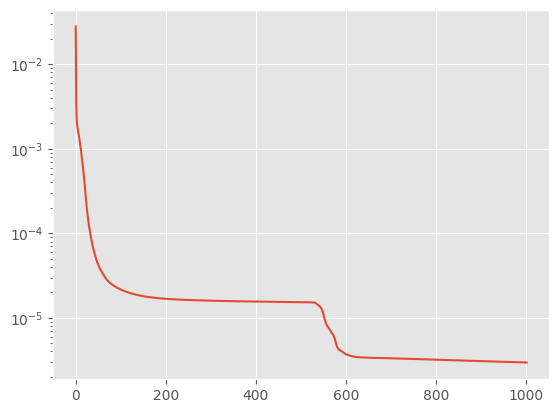

In [11]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize,adaptive_refine_solution
params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(tx_ints[0]))])

params,convergence_data = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)
p_adjusted,refine_convergence_data = adaptive_refine_solution(params,EqnModel,1e-3,500)
plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
plt.yscale('log')
plt.show()

How well do we satisfy the PDE at the ghost points ?

In [12]:
equation_residuals = EqnModel.equation_residual(params)
equation_residuals_refined = EqnModel.equation_residual(p_adjusted)

print("Pre Refinement PDE MSE",jnp.mean(equation_residuals**2))
print("Post Refinement PDE MSE",jnp.mean(equation_residuals_refined**2))

Pre Refinement PDE MSE 1.2952781732689824e-05
Post Refinement PDE MSE 2.315204797192351e-06


In [13]:
u_sols = EqnModel.get_u_params(p_adjusted)
P_sol = EqnModel.get_P_params(p_adjusted)

u_sols = EqnModel.get_u_params(params)
P_sol = EqnModel.get_P_params(params)

In [14]:
print(u_sols)
print(P_sol)

[Array([-3.59498949e-02,  6.51569746e-02, -1.35205310e-01, -3.49535652e-02,
        4.40837771e-02,  9.55434910e-02,  1.06423514e-01,  7.00708708e-02,
        1.37257272e-02, -3.84229643e-02, -7.70279386e-02, -9.54606742e-02,
       -8.68682548e-02, -5.10690119e-02,  1.89155206e-03,  5.76979137e-02,
        1.04146810e-01,  1.31403924e-01,  1.29862715e-01,  9.08875444e-02,
        1.04283028e-02, -1.07953206e-01, -2.54604052e-01, -4.18303446e-01,
       -5.89144818e-01, -7.57416095e-01, -1.73262438e-01,  2.26486054e-01,
       -2.61016116e-01, -3.04737421e-01, -1.12159044e-01,  1.10326061e-01,
        2.59815635e-01,  3.16504153e-01,  2.68264004e-01,  1.24418705e-01,
       -6.98723169e-02, -2.53144474e-01, -3.76724062e-01, -4.13159874e-01,
       -3.52254936e-01, -1.99202374e-01,  2.35455757e-02,  2.75920320e-01,
        5.05033382e-01,  6.53964825e-01,  6.71294824e-01,  5.17866498e-01,
        1.71939328e-01, -3.62071820e-01, -1.03726257e+00, -1.74773849e+00,
       -5.92555294e-02, 

### Measures of accuracy for u's

Results for u_1


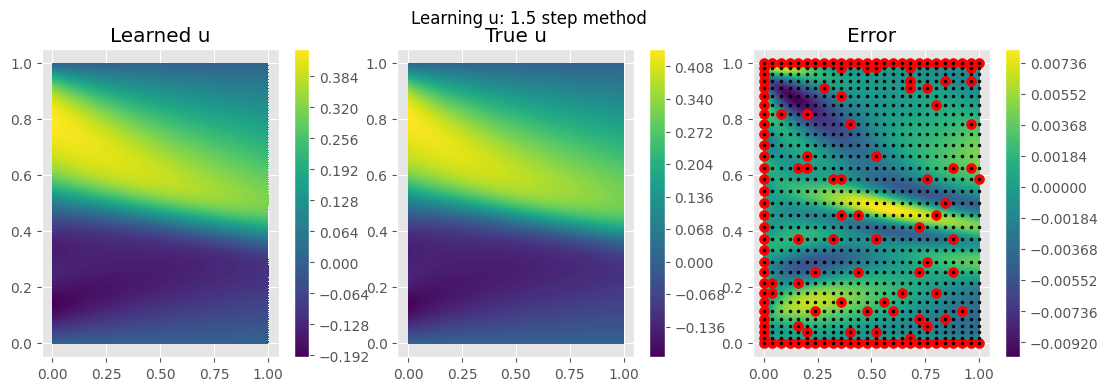

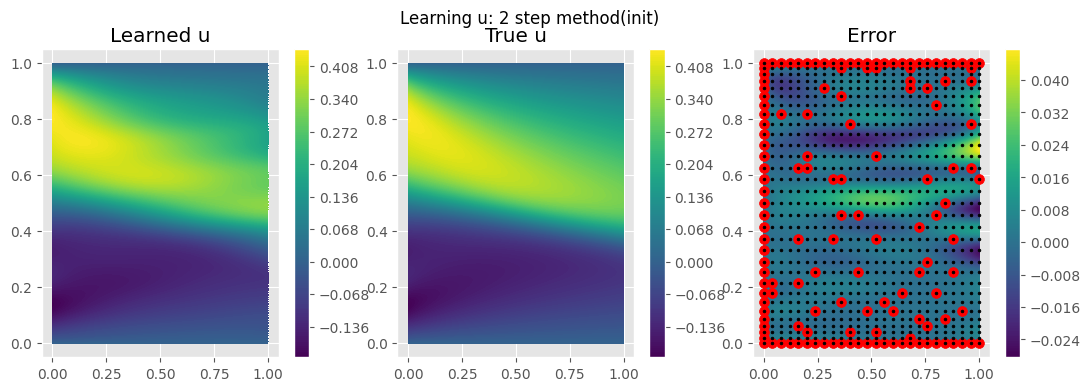

In [15]:
# Compare u's
# for i in range(len(u_true_functions)):
for i in range(m):
    print(f"Results for u_{i+1}")
    # Plot 
    plot_compare_error(tx_fine,
                       tx_all[i],
                       tx_obs[i],
                    lambda x:u_models[i].point_evaluate(x,u_sols[i]),
                    u_true_functions[i]
                    , title = 'Learning u: 1.5 step method')
    plot_compare_error(tx_fine,
                       tx_all[i],
                       tx_obs[i],
                    lambda x:u_models[i].point_evaluate(x,all_u_params_init[i]),
                    u_true_functions[i]
                    , title = 'Learning u: 2 step method(init)')

In [16]:
table_u_errors(
    tx_fine, u_models, u_sols, 
    u_true_functions, 
    all_u_params_init)

,Percent error 1 step,Percent error 2 step (at init)
0,1.331551,3.540634


### Measures of accuracy for P

#### Operator learning error

In [ ]:
# Sample m u0 new functions from a GP
M = 15
kernel_GP = get_gaussianRBF(0.2)
xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
u0_new_true_functions = tuple(GP_Sampler_1D_Pinned(num_samples = M,
                                        X = xy_pts, 
                                        smooth= 2,
                                        kernel = kernel_GP,
                                        reg = 1e-8,
                                        seed = 2025
                                    )
                          )

vec_u0_new_true_functions = tuple([np.vectorize(u) for u in u0_new_true_functions])
vmapped_u0_new_true_functions = tuple([jax.vmap(u) for u in u0_new_true_functions])

# Solve m Burgers' equations with IC's: u0_true_functions 
# kappa = 0.001
# alpha = 5.
kappa = 0.01
alpha = 1.

u_new_true_functions = []
ut_new_true_functions = []
interpolants_new = []
t_vals_s_new = []
sols_s_new = []

for u0_new_true_function in vec_u0_new_true_functions:
  res = list(build_burgers_data(func_u0=u0_new_true_function,
                       kappa = kappa,
                       alpha = alpha,
                       k_timestep=0.0001,
                       n_finite_diff=1999))
  u_new_true_functions.append(res[0])
  ut_new_true_functions.append(res[1])
  interpolants_new.append(res[2])
  t_vals_s_new.append(res[3])
  sols_s_new.append(res[4])

Collocation points for learning u

In [18]:
num_grid_x = 31
num_grid_t = 26
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

tx_all,_ = setup_problem_data(
    tx_int,
    tx_bdy,
    60,
    jax.random.PRNGKey(55),
    times_to_observe = (0,)
)

tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])   

tx_all_ = tx_all[0]

# Object to capture learned solution : Fixing the first ?
u_model = CholInducedRKHS(tx_all,
                            feature_operators,
                            k_u_s[0]
                            )

In [ ]:
def get_u_pde_adj(u0_new,method):
    model_grid_features = EqnModel.get_stacked_eqn_features(u_sols)
    # 1_5 method u_t
    @jit
    def get_pred_ut(input_features):
        return P_model.kernel_function(input_features,model_grid_features)@P_sol
    @jit
    def get_pred_ut_2step(input_features):
        init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
        rhs_stacked = EqnModel.stacked_collocation_rhs
        P_params_naive = P_model.fit_params(init_P_features,rhs_stacked,nugget = 1e-8)
        return P_model.predict_new(input_features,init_P_features,P_params_naive)
    
    new_obs = u0_new(tx_init_bdy) 

    class PdeModel():
        datafit_weight = 50.
        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
            grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
            return jnp.hstack([tx_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return u_model.evaluate_operators((dt_k,),tx_int,u_params)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(tx_init_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = jnp.where(method == 1, get_pred_ut(P_features), get_pred_ut_2step(P_features))
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
        

    # OPTIMIZE
    new_u_init = jnp.zeros(tx_all.shape[0]*len(feature_operators))

    u_params_pde,_ = LevenbergMarquadtMinimize(
        new_u_init.copy(),
        PdeModel,
        beta = 0.,
        max_iter = 101,
        init_alpha=0.05,
        line_search_increase_ratio=1.4,
        print_every = 10
    )
    u_pde_adj,_= adaptive_refine_solution(u_params_pde,PdeModel,1e-1,150)

    return u_pde_adj

# Define grid to test
true = [u(tx_fine) for u in u_new_true_functions]

pred1_5 = [u_model.point_evaluate(tx_fine,get_u_pde_adj(u0,method=1)) for u0 in u_new_true_functions]

pred2 = [u_model.point_evaluate(tx_fine,get_u_pde_adj(u0,method=2)) for u0 in u_new_true_functions]

i_opt_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
i_opt_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

In [27]:
print(f'Operator learning error for 1.5 step method: {round(i_opt_1_5*100,2)} %')

Operator learning error for 1.5 step method:6.92 %


In [29]:
print(f'Operator learning error for 1.5 step method: {round(i_opt_2*100,3)} %')

Operator learning error for 1.5 step method: 43.656 %
